In [41]:
import numpy as np
np.random.seed(4)
#以下代码：dataset从一个维度为p0的teacher model中生成，而用来拟合的模型的维度则为p。
#gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
#teacher model
#dimension of x: d（固定不变）
d = 10
#number of training samples（固定不变）
N = 100
#dimension of hypothesis space
p0 = 5 #dimension of teacher model（固定不变）
p = 200 #dimension of student model（可变）
p_max = 2000 #upper bound of dimension of student model（固定不变）

#point-wise activate function f:tanh
#variance of random noise added to y
sigma = 0.1

#random feature matrix F(d*p)
F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
F = np.random.normal(0,1,(d,p_max))[:,0:p] #生成student model的random feature matrix F，先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
    #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
#teacher parameter w(p) with lambda = ? until each dim of Y~1e0
lambda_ = 0.0001
#w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
#w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)
'''
以下为采样一个(S,W)元组的起点。
'''
#samples X(N*d) 在采样每一个(S,W)元组的时候，最根本的就是在此处采样一个S（通过采样X）=(X,Y)，然后根据S训练得到一个W，这样就完成了一个元组的采样。采样K个(S,W)元组就是把上述过程重复K次。
X = np.random.normal(0,1,(N,d)) #生成N个d维随机向量，作为N条样本组成的训练集。X经过F0和w_0的作用后再加上高斯扰动（这个扰动是必要的，不然构成确定映射不影响互信息）形成的Y与X一起构成了从dataset里采样的N个样本，对应了论文中的=>S （可变）
#X after the random feature matrix
X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
X_rf = np.tanh(X.dot(F)/np.sqrt(d))
Y_pure = X_rf0.dot(w_0)
Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y。同时，S=(X,Y)
# 以上过程就采样了一个S，接下来将在S的条件下，以P_{W|S}（也就是gibbs分布）采样一个W，从而构成(S,W)元组。此后均由算法自动完成。
print(Y_pure)
print(Y)
w_0.shape

[-0.02691137 -1.3371554   1.57523733 -0.97544849  0.0905622   2.0772763
  0.99630333  0.26586602  1.75489367  1.20376137  0.99171432 -0.47462123
 -0.27158372  1.45053301  1.01225048 -0.10927819  1.36729158 -3.25427024
  1.25166676 -2.32269972 -2.31519829  0.83293332 -0.58420714 -3.04866254
  0.21504826 -0.0825935  -0.48273057 -0.24815245 -2.02964336 -0.52631979
 -2.733073    0.4938588  -0.91221643  2.02222781 -3.28537758  1.36853594
  1.0855464  -2.12314266  2.36979845  0.35808065 -2.07786504 -0.98756516
 -0.46428982  1.47998644 -1.78696608 -0.67133223 -2.13349505  1.49797977
 -1.11440321  2.13924599 -1.87858952 -3.05293914  0.54952825 -2.48988418
  1.93250516 -0.25509145 -2.29736679  1.03868083 -1.70938904  1.79545778
  1.72217381  1.85869904  2.93342478 -0.17562018 -2.54476574  0.56553297
  0.02644127 -1.13497023  1.46448057 -0.96320117  0.42746875  1.15061537
 -2.69448068 -1.52624586 -0.49977017 -1.71155695  2.40501157  1.37303508
  1.87055015  0.66054125  1.46722345  2.27767198 -0.

(5,)

In [42]:
#empirical risk
#L_S(w)
def L_S(w):
    diff = Y-X_rf.dot(w)
    Nloss = diff.dot(diff)
    return Nloss/N

def grad_L_S(w):
    return -2/N*X_rf.T.dot(Y-X_rf.dot(w))

#grad_L_S(w_0+0.1)#when N is small, diffusion.

In [43]:
#minus log distribution: f
#prar beta(also change h if change this)
beta = 10000
#para sigma_q, can be set according to N.
sigma_q = 0.5
def f(w): 
    return beta*L_S(w)+(1/2/sigma_q**2)*(w.dot(w))

def grad_f(w):
    grad = beta*grad_L_S(w)+1/sigma_q**2*w
    return grad

In [44]:
import matplotlib.pyplot as plt
#fig1, ax1 = plt.subplots(figsize = (10,5), dpi = 200)
x = [] #画图用的
y = [] #画图用的
w_samples = [] #画图用的
#MCMC
#stepsize h(h*beta=0.01)
h = 0.01/beta
w = np.random.normal(0,5,p)/p #MCMC的初始分布，如何设置？可直接设为0？这事关MCMC的收敛问题，有些问题有待考证
#resdet random seed
np.random.seed(11)
for i in range(80000): #迭代次数要使MCMC收敛到平稳分布才行。这里足够了吗？我不知道。需要看老师发的那篇文献。。
    grad_f_w = grad_f(w)
    proposal_state = w-h*grad_f_w+np.sqrt(2*h)*np.random.normal(0,1,p)
    reject_thresh = min(1,np.exp(f(w)-f(proposal_state)+(1/4/h)*(np.linalg.norm(proposal_state-w+h*grad_f_w)**2-np.linalg.norm(w-proposal_state+h*grad_f(proposal_state))**2)))
    U = np.random.rand(1)
    if U <= reject_thresh:
        w = proposal_state
    if i%100 == 0:#画图用的
        x.append(int(i))
        y.append(w[6])
    if i>10000 and i%1000 == 0:#画图用的
        w_samples.append(w)
#到此处W采样结束，已经形成了一个(S,W)元组。
'''
以上为采样一个(S,W)元组的终点。后面是一些分析和画图的代码
'''
#画图用的
x = np.array(x)
y = np.array(y)
'''
ax1.plot(x,y)
plt.savefig('(5,10,0.1).png')
plt.show()
'''
#print(w)
#print(w_0)

"\nax1.plot(x,y)\nplt.savefig('(5,10,0.1).png')\nplt.show()\n"

In [45]:
X_t = np.random.normal(0,1,(1000,d))
X_rf_t0 = np.tanh(X_t.dot(F0)/np.sqrt(d))
X_rf_t = np.tanh(X_t.dot(F)/np.sqrt(d))

Y_pure_t = X_rf_t0.dot(w_0)
bias = np.random.normal(0,sigma,1000)
Y_t = Y_pure_t + bias

diff_t = Y_pure_t-X_rf_t.dot(w)
Nloss_t = diff_t.dot(diff_t)

print(bias.dot(bias)/1000)
print(Nloss_t/1000)
print(Y_pure_t[0:20])
print(X_rf_t.dot(w)[0:20])
print(Y_pure[0:20])
print(X_rf.dot(w)[0:20])

0.01012683641954508
0.5631095363880034
[ 1.37363052  1.24215714 -3.83941449 -1.28271937  1.55238419 -0.40002748
  1.91253932 -1.9329011  -2.22629236  0.32821069  2.01389789 -1.74310288
 -0.5255286  -1.01570168  0.49503611  3.60481254 -1.29111991 -2.96952001
 -3.48578869 -2.49231275]
[-0.2145812   1.54559763 -3.97533034 -0.81024066  2.01572546  0.56216214
  2.3841471  -1.78339507 -3.26274535  1.54652724  2.11116558 -2.11223054
  0.8211549  -1.45937524  1.14249421  4.2003915  -0.2224138  -3.29156489
 -4.4006833  -2.61300943]
[-0.02691137 -1.3371554   1.57523733 -0.97544849  0.0905622   2.0772763
  0.99630333  0.26586602  1.75489367  1.20376137  0.99171432 -0.47462123
 -0.27158372  1.45053301  1.01225048 -0.10927819  1.36729158 -3.25427024
  1.25166676 -2.32269972]
[ 0.04005714 -1.15014815  1.35386622 -0.89832044 -0.01621192  2.02980001
  1.01531015  0.40365425  1.77388346  0.95192354  1.09691794 -0.61134305
 -0.3269786   1.62216937  0.81307329 -0.04852834  1.30140297 -3.25381095
  1.3051

(d, N, p0, p, p_max) = (10, 100, 5, 200, 2000) => 0.5260618779186569 EARLY STOP!


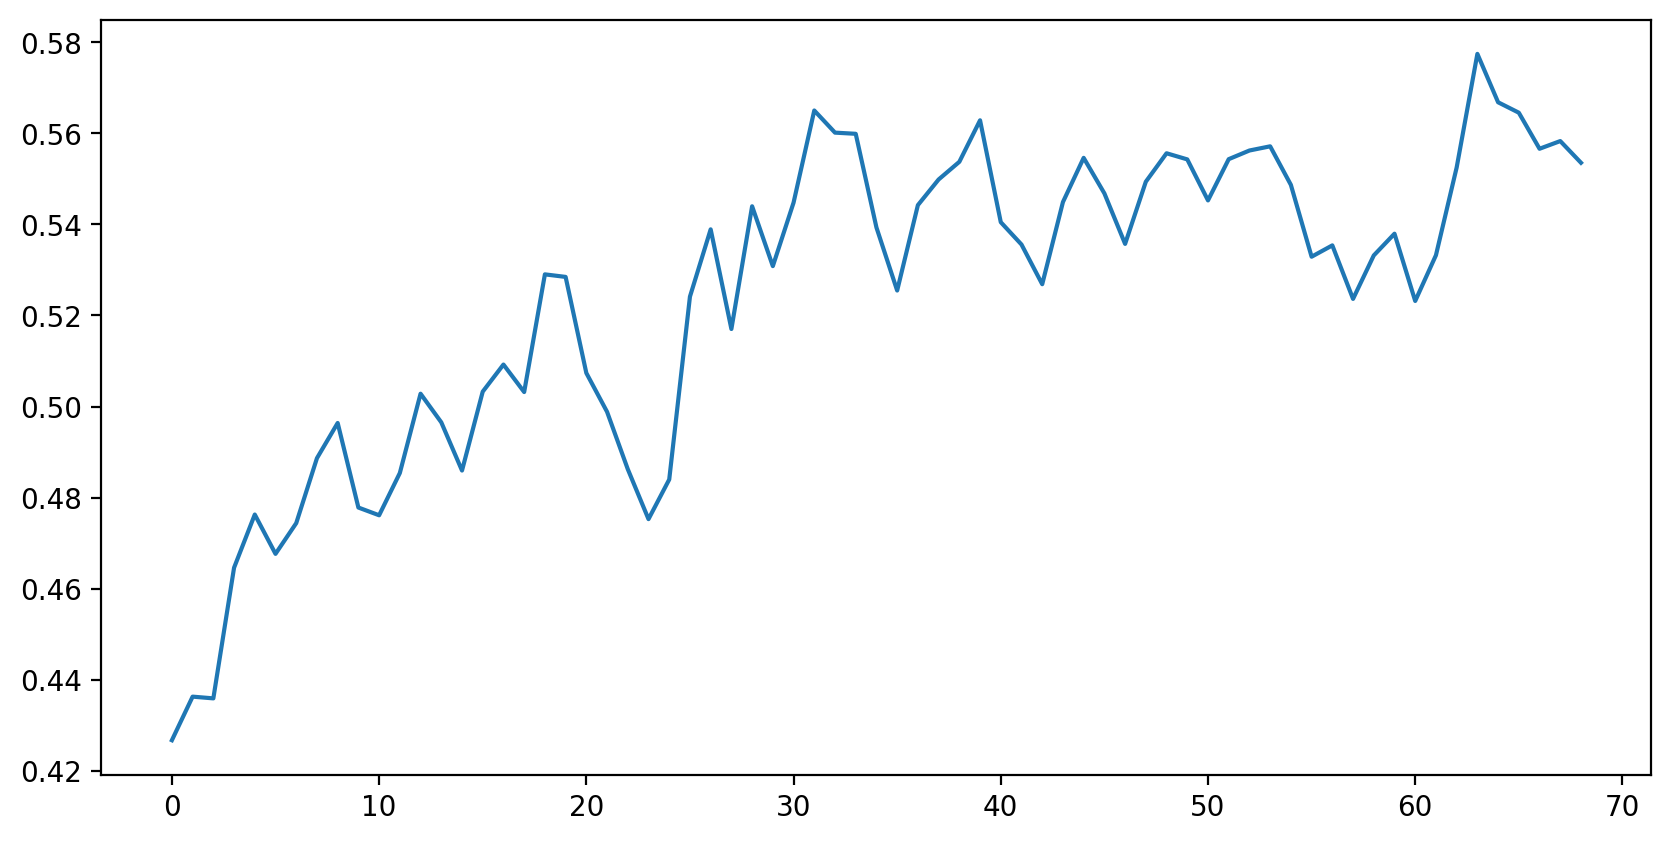

In [46]:
losses = []
for i in range(len(w_samples)):
    w_cur = w_samples[i]
    diff_t = Y_pure_t-X_rf_t.dot(w_cur)
    Nloss_t = diff_t.dot(diff_t)
    losses.append(Nloss_t/1000)
fig2, ax2 = plt.subplots(figsize = (10,5), dpi = 200)
ax2.plot(np.arange(len(w_samples)),losses)
#plt.savefig('loss-epoch_3alt')
plt.show()

w = [-0.55882486,  0.65422815,  1.3952349 , -1.66160902,  0.44195276,
        1.61259181,  0.05600595,  0.37203954, -1.53383879,  0.32830111,
       -0.0983585 ,  0.57222052,  0.57214638,  0.34819127, -1.67546279,
       -1.09869673,  0.36316559, -0.76966768, -0.89687785, -0.43751918,
       -1.08800011, -0.6944636 ,  1.57249456, -0.81109419,  1.60943365,
       -0.8660595 ,  0.36791259,  0.3719302 ,  1.49473734, -0.79650838,
        0.18257012,  0.35319776,  1.11816069, -1.0947475 ,  0.76880982,
       -1.30758606, -3.54685392,  0.85866685,  0.69514779,  0.50306545,
        0.61308029,  1.58236903,  0.54434561, -1.14060486,  0.28511037,
        0.59045815,  0.74339481, -0.04719104,  1.04087841, -0.66079707,
       -0.53639483,  0.65607258,  0.87351304, -1.9283235 , -0.04641502,
       -0.48867673, -0.78742415, -0.28975134,  0.42722906,  2.80474535,
       -0.74931496,  0.04414841, -1.21380619, -1.48641884,  2.18307483,
        0.98514709,  1.21388059, -0.36539871,  0.41439813, -0.42325078,
       -0.60146365,  0.68894604,  0.78863385,  0.13504367,  0.95352865,
        0.44066866, -0.42791643,  1.56884639,  1.50446746,  1.68680989,
       -0.79530193, -1.80874923, -0.43165425, -1.23302902,  1.09293741,
       -0.21070505,  0.70575914, -0.20713036, -0.82147564, -0.64617294,
       -0.55089841,  0.55913312, -0.99202659,  0.31454942,  1.42758246,
        0.17806335,  0.80339803, -0.67146406,  1.15587523,  2.61938715,
       -0.28338457,  0.55939253, -0.63578857, -0.20294178, -0.45779331,
       -1.67655371, -0.36140919,  0.70807905,  0.46431945,  1.88521603,
        0.77923538,  0.19731686, -0.90623815, -1.6550677 , -0.50581993,
        0.34985407, -1.54536728,  0.15420823, -0.34626903,  0.77533151,
        0.09979406, -0.43715616,  1.45159662,  0.02250795,  1.87434525,
       -0.04051393, -0.71739584,  1.11724841,  0.16263274, -0.51970978,
       -0.21355137, -0.49525482,  0.27795588,  1.65518689, -0.10092971,
       -0.85384913, -1.72357838,  1.23364198,  0.67424027, -0.50299856,
        0.46929804, -1.04742409, -0.31661383, -0.79520192, -0.42070516,
        0.4591046 ,  0.61977489, -0.79981017, -2.68710721, -0.37996623,
       -0.25460932,  0.21127548,  0.75407288, -0.09190113, -1.63847856,
       -0.4852109 ,  0.14967657, -0.8834521 ,  0.3070932 , -0.10089333,
       -1.42504107,  0.25352155,  0.4820038 ,  0.01472441, -2.39777163,
       -1.9550517 , -0.00733209,  0.35406883, -0.35356054, -0.11284931,
       -0.24126005, -2.94972151,  1.53595919,  0.05889572,  1.15041631,
       -0.00913075,  1.3634635 , -1.76043282,  0.19359095, -0.85764462,
       -1.04432053,  0.65512592,  0.64929442, -0.50918566, -0.94674513,
        0.88755194, -0.47532471, -1.28068161,  1.37134893, -0.26979471,
        0.82855622,  0.02504934, -1.14443155, -0.14317558, -0.72749756,
       -1.78675513, -1.26671857,  1.34215783, -0.12123356, -2.26970078]

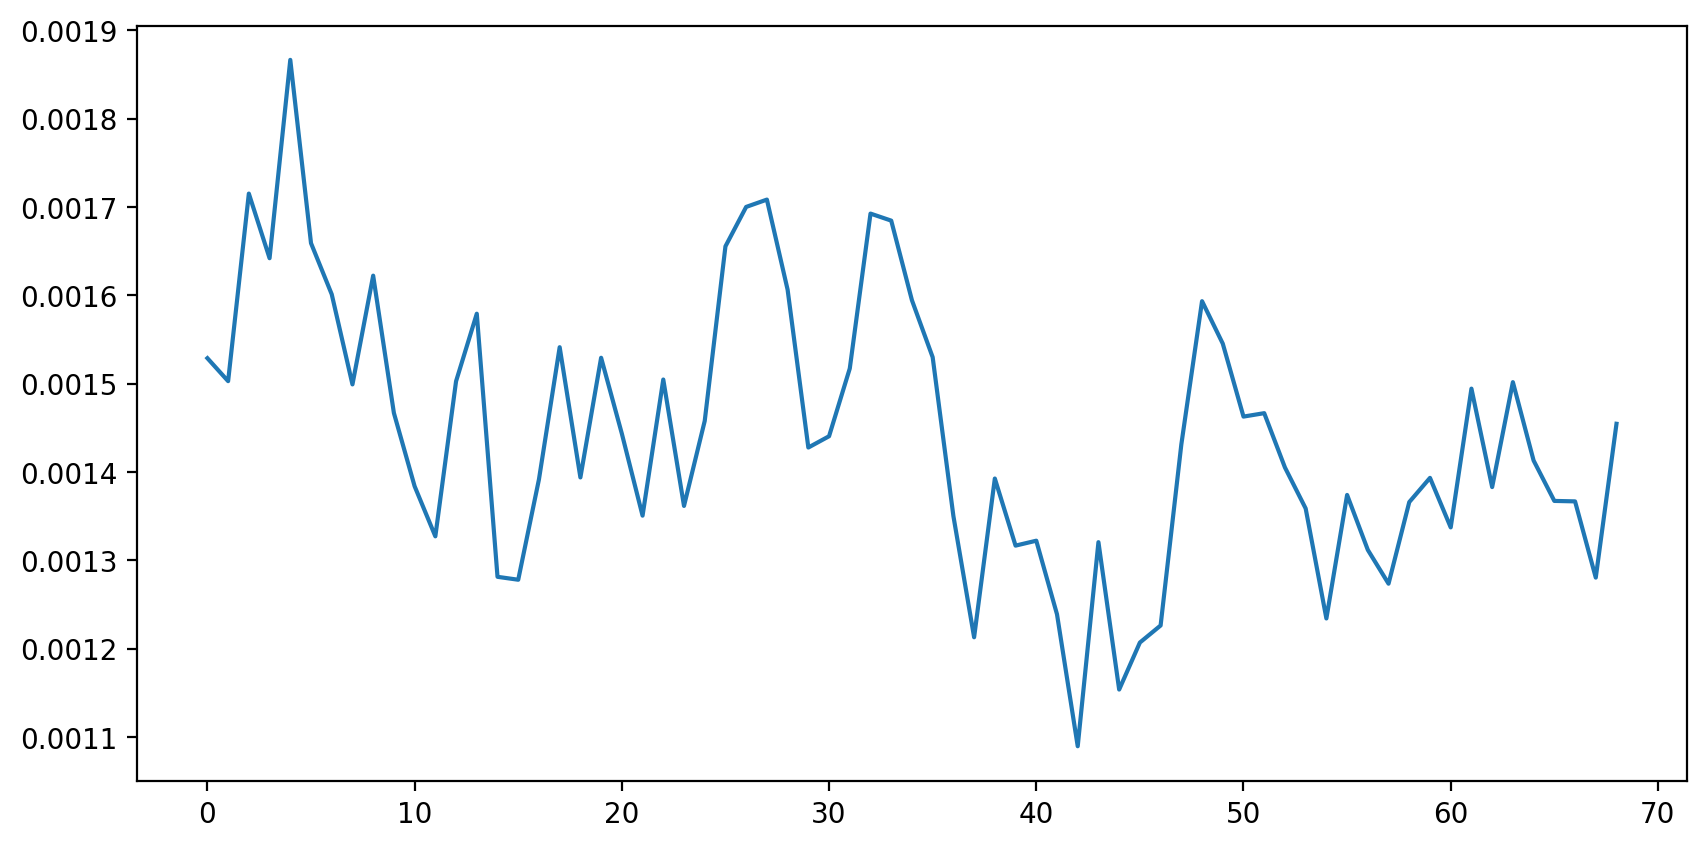

In [47]:
t_losses = []
for i in range(len(w_samples)):
    w_cur = w_samples[i]
    diff = Y_pure-X_rf.dot(w_cur)
    Nloss_t = diff.dot(diff)
    t_losses.append(Nloss_t/1000)
fig3, ax3 = plt.subplots(figsize = (10,5), dpi = 200)
ax3.plot(np.arange(len(w_samples)),t_losses)
#plt.savefig('trainloss-epoch_3alt')
plt.show()

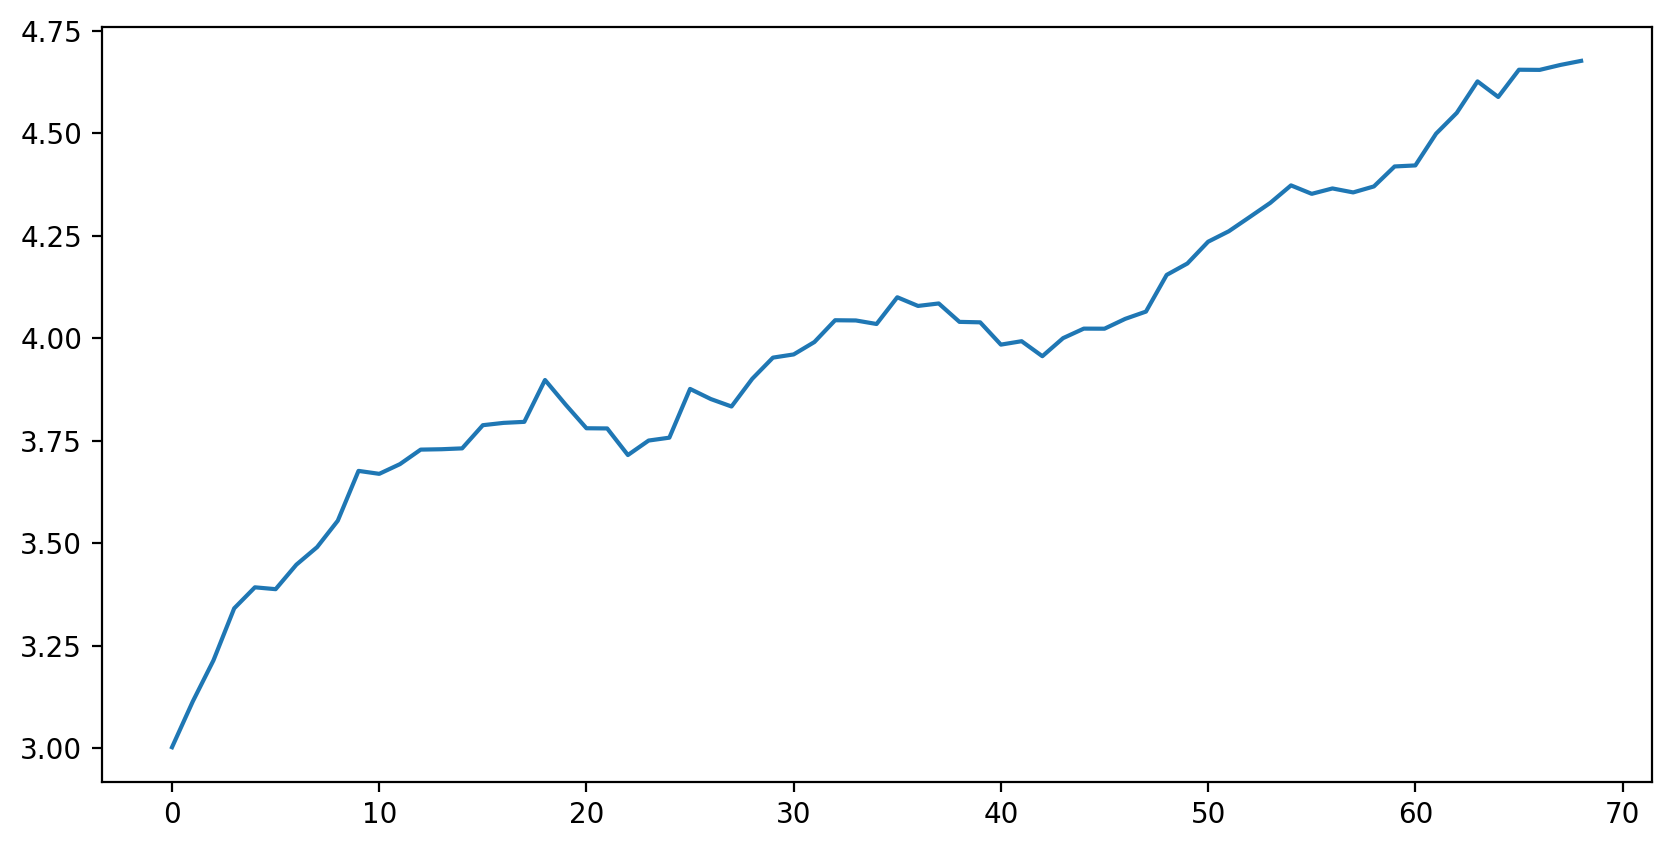

In [48]:
w_norms = []
for i in range(len(w_samples)):
    w_cur = w_samples[i]
    w_norms.append(np.linalg.norm(w_cur))
fig4, ax4 = plt.subplots(figsize = (10,5), dpi = 200)
ax4.plot(np.arange(len(w_samples)),w_norms)
#plt.savefig('norm-epoch_3alt')
plt.show()